## **2-Layer Moist Energy Balance Model**

In [1]:
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
import matplotlib.colors as colors

## **Set Up**

### Set time step, model duration, model grid, and heat capacity for mixed and deep layers

In [2]:
#time step in fraction of year
#delt=1./50000
speryear=60*60*24*365
itperyear=1000
runyears=500
dt=speryear/itperyear
NMAX=itperyear*runyears

#set up grid for model (x = sine of latitude).
jmx=101; #number of grid points (don't change this for this homework set!)
delx = 2.0/jmx;
x = np.arange(-1.0+delx/2,1.0,delx) #grid points
phi = np.arcsin(x)*180/np.pi; #latitude at each grid point

#Cl = 0.2; # heat capacity, units: J /(m2 K) consistent with 1 meter of dirt (low heat capacitity for fast convergence)
sea_rho = 1025 #density of sea water
cw = 3850 #specific heat of sea water
h = 70 #depth of upper layer, units: (m)
h0 = 1100 #depth of deep layer, units: (m)
C = sea_rho*cw*h #heat capacity of upper layer, units: (J)/(m2 K)
C0 = sea_rho*cw*h0 #heat capacity of deep layer, units: (J)/(m2 K)
gamma = 0.7 #Ocean heat uptake efficiency, units: W/(m2 K)

#### Varible Mixed Layer Depth (optional)

In [ ]:
# # Uncomment the following lines for variable mixed layer depth

# h = np.zeros(101)
# h0 = np.zeros(101)
# C = np.zeros(101)
# C0= np.zeros(101)

# h = np.zeros(101)
# h0=np.zeros(101)
# C = np.zeros(101)
# C0= np.zeros(101)

In [ ]:
# # # Uncomment the following lines for variable mixed layer depth 

# # # Ocean heat capacity with uniform layer depths using default values
# # h[0:101] = 70
# # C[0:101] = sea_rho*cw*h
# # h0[0:101] = 1100
# # C0[0:101] = sea_rho*cw*h0

# # # Ocean heat capacity with deeper mixed layer at 30N and 30S
# # h[0:101] = 70
# # h[25:35] = 300
# # h[65:85] = 500
# # C[0:101] = sea_rho*cw*h
# # h0[0:101] = 1100
# # C0[0:101] = sea_rho*cw*h0

# # # Ocean heat capacity with mixed layer depth increasing poleward
# delh = 5
# hMax = 500
# for i in range(101):
#     if i <= 50:
#         h[i] = hMax - (delh * i)
#     if i > 50:
#         h[i] = hMax - (delh * (101 - i))
#     if h[i] < 1:
#             h[i] = 1
# C[0:101] = sea_rho*cw*h
# h0[0:101] = 1100
# C0[0:101] = sea_rho*cw*h0

# #plot layer depths
# plt.plot(phi, np.zeros(101))
# plt.plot(phi, 0 - h)
# plt.plot(phi, 0 - h0)
# plt.xticks(np.arange(-90, 91, 30))
# plt.xlabel('latitude', fontsize=14)
# plt.ylabel('Depth (m)', fontsize=14)
# plt.legend(["Surface", "Mixed Layer", "Deep Layer"], loc="right")
# plt.show()

### Set moisture paramaters and diffusivity

In [3]:
# Moisture parameters
relhum = 0.8;   # relative humidity
eps = 0.622;    # moisture coonstant
psfc = 9.8e4;   # (Pa)
e0 = 611.2;     # vap. press (Pa)
a = 17.67; b = 243.5;   # sat vap constants !!T must be in temperature
L = 2.45e6;         # latent heat of vaporization (J kg-1)
cp = 1004;          # (J kg-1 K-1)

# magnitude of diffusivity
Dmag = 0.2598; # D = 0.2598 W/(m2 K) is the value used by TF10 
D=Dmag*np.ones(jmx+1); # diffusivity for MSE

### Load climatological temperature data and solve for climatological q and theta_e

In [4]:
#load in the climatological temperature from ERA-Interim for the control climate
matLabData = io.loadmat('ERAtemperature.mat') #loads matlab file as a dictionary with some metadata
#matLabData.keys() #tell me what's in the dictionary
lat = np.asarray(matLabData['lat'])
T_ctrl = np.asarray(matLabData['T'])
# uncomment this line to symmetrize the assumed climatological temperature
# T_ctrl = 0.5*(T_ctrl+np.flipud(T_ctrl)); # average N & S hemispheres for symmetry
T_ctrl.shape
from scipy.interpolate import griddata
T_ctrl = griddata(np.sin(np.deg2rad(lat)), T_ctrl, x, method='linear') #interp1(sind(lat),T_ctrl,x,'linear');
T_ctrl = np.squeeze(T_ctrl, axis=1)
q_ctrl = eps*relhum/psfc*e0*np.exp(a*(T_ctrl)/(b+(T_ctrl)));  #q=q(:); # here T is in oC. q is g kg-1
theta_e_ctrl = 1/cp*(cp*((T_ctrl)+273.15) + L*q_ctrl); #theta is mse divided by cp. note units of Kelvin are needed!!!

### Load forcing and feedbacks from CMIP5

In [5]:
#CMIP5 ensemble-mean feedback and forcing values from 4xCO2 simulations (taken at year 100)
matLabData = io.loadmat('CMIP5_Rf_lambda_G.mat') #feedback, forcing, and heat uptake 
CMIP5_lat = np.asarray(matLabData['lat']) #latitude
feedback = np.squeeze(griddata(CMIP5_lat,np.asarray(matLabData['lambda_total']),phi, method='linear')) #Radiative feedback
Rf = np.squeeze(griddata(CMIP5_lat,np.asarray(matLabData['Rf']),phi, method='linear')) #Radiative forcing
#G = np.squeeze(griddata(CMIP5_lat,np.asarray(matLabData['G']),phi, method='linear')) #Ocean heat uptake

G = 0*np.ones(x.size) # uncomment to set ocean heat uptake to zero 
R_frc = Rf + G #CO2 forcing (Rf) with ocean heat uptake (G)

### Plot radiative feedback and forcing

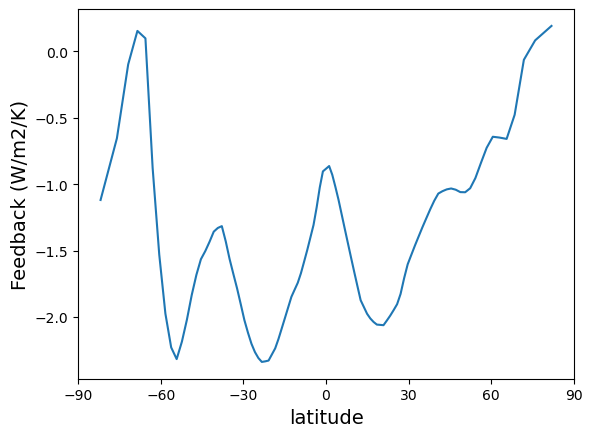

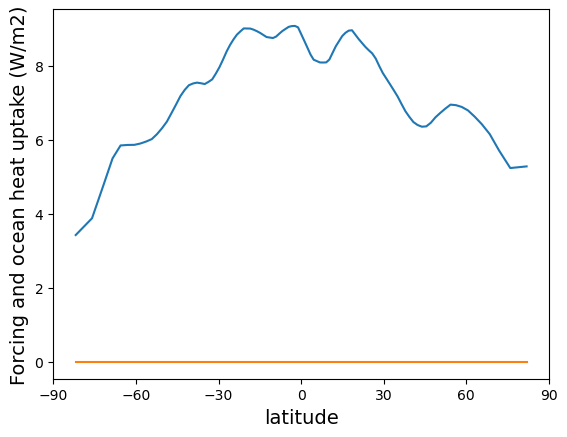

In [6]:
#plot net feedback, forcing, and ocean heat uptake you're using
plt.plot(phi,feedback)
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('latitude', fontsize=14)
plt.ylabel('Feedback (W/m2/K)', fontsize=14)
plt.show()

plt.plot(phi,Rf)
plt.plot(phi,G)
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('latitude', fontsize=14)
plt.ylabel('Forcing and ocean heat uptake (W/m2)', fontsize=14)
plt.show()

## **Set up and run coupled MEBM and 2-layer atmosphere**

### Create divergence matrix

In [7]:
#Create matrix to take a divergence of something it acts on   
#set up lambda array.
lam=(1-np.square(np.arange(-1.0,1.0+delx,delx)))/np.square(delx);
lam=np.multiply(D, lam); 

M = np.zeros((jmx,jmx));

M[0,0] =  - lam[1];
M[0,1] = lam[1];

M[jmx-1,jmx-2] = lam[jmx-1];
M[jmx-1,jmx-1]   = - lam[jmx-1];

for j in range(1, jmx-1): 
  M[j,j-1] = lam[j]
  
  M[j,j]   = - (lam[j+1]+lam[j])
  
  M[j,j+1] = lam[j+1]


Mdiv = M; #Divergence matrix 

### Define parameters and Hadley Cell 

In [8]:
Re = 6.4e6;                 # [m] earth's radius
rho = 1e3;                  # [kg m-3] density
wt = 1-norm.pdf(x, 0, np.sin(15*2*np.pi/360))/norm.pdf(0, 0, np.sin(15*2*np.pi/360)) # define Gaussian Hadley Cell width wt = 1-gaussmf(x,[sind(15) 0]);

### Set up matrices for the model to save iterations to. Set initialization temperature profile.

In [9]:
# Now solve climate change experiment
#set up inital T profile 
T = np.zeros((101,NMAX-1))
#T[:,0] = 0.5*(1-1*x*x)
Tinit=T[:,0].copy()
Tglob = np.mean(Tinit)

T0init = Tinit.copy()
T0 = T.copy()
T0glob = Tglob.copy()
#T.shape

F_expt = np.zeros((101,NMAX-1))
F_LH_expt = np.zeros((101,NMAX-1))
F_LH_eddy_expt = np.zeros((101,NMAX-1))
V_expt = np.zeros((101,NMAX-1))
q_expt = np.zeros((101,NMAX-1))
E_m_P_expt = np.zeros((101,NMAX-1))
E_expt = np.zeros((101,NMAX-1))
P_expt = np.zeros((101,NMAX-1))

### Calculate historic climatological variables

In [10]:
# calculate some things about the control climate (ctrl) prior to 4xCO2 perturbation
Dhlf = Dmag*np.ones(jmx)                                   # [W m-2 K-1] calculate D on same grid as T,q, etc ##0.5*(D(1:end-1)+D(2:end));  #WARNING: would need to modify this if allowing D to vary with latitude
h_ctrl = cp*(T_ctrl+273.15)+L*q_ctrl                       # [J kg-1] control climate mse
F_ctrl = -2*np.pi*np.square(Re)/cp*Dhlf*(1-np.square(x))*np.gradient(h_ctrl,x)  # [W] control climate flux 
F_lh_ctrl = -2*np.pi*np.square(Re)/cp*Dhlf*(1-np.square(x))*np.gradient(L*q_ctrl,x)    # [W] control latent heat flux
F_hc_ctrl = (1-wt)*F_ctrl                                 # [W] Hadley Cell Flux
heq_ctrl = h_ctrl[50]                                 #value at equator WARNING will have to change if change grid ; # [J kg-1] moist static energy at the surface
V_ctrl = F_hc_ctrl/(heq_ctrl*1.07-h_ctrl)               # [kg s-1] Diagnosed mass transport in Hadley Cell (Nick's way)
F_LH_ctrl = -L*V_ctrl*q_ctrl + wt*F_lh_ctrl              # [W] latent heat (Hadley plus eddy)
F_LH_eddy_ctrl = wt*F_lh_ctrl                         # eddy latent heat fluxes including weighting function.
divF_LH_ctrl = 1/(2*np.pi*np.square(Re))*np.gradient(F_LH_ctrl,x)         # [W m-2] divergence of latent heat flux
E_m_P_ctrl = divF_LH_ctrl/(L*rho)*np.pi*1e7                   # [m yr-1]E-P
# code from Nick Siler to partition E-P;
alpha=L/461.5/np.square(T_ctrl+273.15)                         # Nick's alpha parameter
beta=cp/L/alpha/q_ctrl                                   # beta parameter
RG=180*(1*(1-np.square(x))-.4*np.exp(-np.square((x/.15))))                   # [W m-2] idealized R-G
Ch=1.5e-3                                                  # drag coefficient
LWfb=0                                                     # LW feedback at surface, in W/m2/K
u=4+np.abs(np.sin(np.pi*x/1.5))*4; #-2.5*cos(3*np.arcsin(x))     # wind speed
rho_air=1.2       #psfc/287/(T_ctrl+273.15)               # air density
E_ctrl=(RG*alpha+rho_air*cp*(1-relhum)*Ch*u)/(alpha+cp/L/q_ctrl)
P_ctrl=E_ctrl-divF_LH_ctrl

### Set up initial profile of hydrologic variables (redundant step)

In [11]:
q = eps*relhum/psfc*e0*np.exp(a*(T[:,0]+T_ctrl)/(b+(T[:,0]+T_ctrl))) # here T is in oC. q is g kg-1   
theta_e = 1/cp*(cp*((T[:,0]+T_ctrl)+273.15) + L*q) # note units of Kelvin are needed!!!
theta_e_pert = theta_e-theta_e_ctrl #anomalous theta_e

q_expt[:,0] = q
q_pert = q_expt[:,0]-q_ctrl
divF_pert = -Mdiv*theta_e_pert
h_pert = theta_e_pert*cp
T_pert = T[:,0]
T_expt = T[:,0]+T_ctrl

h_expt = h_ctrl+h_pert                                 # [J kg-1] new total mse
F_expt[:,0] = -2*np.pi*np.square(Re)/cp*Dhlf*(1-np.square(x))*np.gradient(h_expt,x)      # [W] new total flux
F_lh_expt = -2*np.pi*np.square(Re)/cp*Dhlf*(1-np.square(x))*np.gradient(L*q_expt[:,0],x)    # [W] control latent heat flux
F_hc_expt = (1-wt)*F_expt[:,0]                             # [W] Hadley Cell Flux
heq_expt = h_expt[50]                                # [J kg-1] moist static energy at the surface
V_expt[:,0] = F_hc_expt/(heq_expt*1.07-h_expt)           # [wkg s-1] Diagnosed mass transport in Hadley Cell
F_LH_expt[:,0] = -L*V_expt[:,0]*q_expt[:,0] + wt*F_lh_expt          # [W] latent heat (Hadley plus eddy)
F_LH_eddy_expt[:,0] = wt*F_lh_expt                         # eddy latent heat fluxes including weighting function.
divF_LH_expt = 1/(2*np.pi*np.square(Re))*np.gradient(F_LH_expt[:,0],x)      # [W m-2]
E_m_P_expt[:,0] = divF_LH_expt/(L*rho)*np.pi*1e7               # [m yr-1] E-P
alpha=L/461.5/np.square(T_expt+273.15)                         # Nick's alpha parameter
beta=cp/L/alpha/q_expt[:,0]                                   # beta parameter
Rv = 461 #gas constant for H20 vapor
alf = L/(Rv*np.square(T_ctrl+273.15)) # Clausius-Clapeyron scaling 1/q*dq/dT
beta = cp/(alf*q_ctrl*L) # Bowen ratio
E_pert = (E_ctrl*T_pert*beta*(alf-2/(T_ctrl+273.15))-G)/(1+beta)
E_expt[:,0] = E_ctrl+E_pert
P_expt[:,0]=E_expt[:,0]-divF_LH_expt

### Iterate through model

In [12]:
# Timestepping loop. Note that it takes ~30 seconds to run this part
for j in range(1, NMAX-1):
   
    #print(np.mean(T)) 
       
    # spec. hum, and theta_e
    q = eps*relhum/psfc*e0*np.exp(a*(T[:,j-1]+T_ctrl)/(b+(T[:,j-1]+T_ctrl))) # here T is in oC. q is g kg-1
   
    theta_e = 1/cp*(cp*((T[:,j-1]+T_ctrl)+273.15) + L*q) # note units of Kelvin are needed!!!
   
    theta_e_pert = theta_e-theta_e_ctrl #anomalous theta_e
    
    # Calculate new T from Source and Sink terms.
    # Diffuse anomalous moist static energy (theta_e_pert)
    #dT = delt/Cl*(R_frc + (feedback*T[:,j-1]) + np.matmul(Mdiv,theta_e_pert))
    #T[:,j] = T[:,j-1] + dT;
    
    T[:,j] = T[:,j-1] +(dt/C)*(R_frc + feedback*T[:,j-1]-gamma*(T[:,j-1]-T0[:,j-1]) + np.matmul(Mdiv,theta_e_pert))
    T0[:,j] = T0[:,j-1]+(dt/C0)*gamma*(T[:,j-1]-T0[:,j-1])

    q_expt[:,j] = q
    q_pert = q_expt[:,j]-q_ctrl
    divF_pert = -Mdiv*theta_e_pert
    h_pert = theta_e_pert*cp
    T_pert = T[:,j]
    T_expt = T[:,j]+T_ctrl
    
    # calculate some things about the new climate state (expt) under 4xCO2 forcing
    h_expt = h_ctrl+h_pert                                 # [J kg-1] new total mse
    F_expt[:,j] = -2*np.pi*np.square(Re)/cp*Dhlf*(1-np.square(x))*np.gradient(h_expt,x)      # [W] new total flux
    F_lh_expt = -2*np.pi*np.square(Re)/cp*Dhlf*(1-np.square(x))*np.gradient(L*q_expt[:,j],x)    # [W] control latent heat flux
    F_hc_expt = (1-wt)*F_expt[:,j]                             # [W] Hadley Cell Flux
    heq_expt = h_expt[50]                                # [J kg-1] moist static energy at the surface
    V_expt[:,j] = F_hc_expt/(heq_expt*1.07-h_expt)           # [wkg s-1] Diagnosed mass transport in Hadley Cell
    F_LH_expt[:,j] = -L*V_expt[:,j]*q_expt[:,j] + wt*F_lh_expt          # [W] latent heat (Hadley plus eddy)
    F_LH_eddy_expt[:,j] = wt*F_lh_expt                         # eddy latent heat fluxes including weighting function.
    divF_LH_expt = 1/(2*np.pi*np.square(Re))*np.gradient(F_LH_expt[:,j],x)      # [W m-2]
    E_m_P_expt[:,j] = divF_LH_expt/(L*rho)*np.pi*1e7               # [m yr-1] E-P
    alpha=L/461.5/np.square(T_expt+273.15)                         # Nick's alpha parameter
    beta=cp/L/alpha/q_expt[:,j]                                   # beta parameter
    Rv = 461 #gas constant for H20 vapor
    alf = L/(Rv*np.square(T_ctrl+273.15)) # Clausius-Clapeyron scaling 1/q*dq/dT
    beta = cp/(alf*q_ctrl*L) # Bowen ratio
    E_pert = (E_ctrl*T_pert*beta*(alf-2/(T_ctrl+273.15))-G)/(1+beta)
    E_expt[:,j] = E_ctrl+E_pert
    P_expt[:,j]=E_expt[:,j]-divF_LH_expt
    
    #Check to see if global mean energy budget has converged:   
    Fglob=np.mean(R_frc + (feedback*T[:,j]))
    
    if np.absolute(Fglob) < 0.001: #if (abs(Fglob) < 0.001), break; end
        final_iteration = j
        print("Global mean energy budget converged")
        break  
    if (j==NMAX-2):
        final_iteration = j
        print("Reached final iteration")
# print(Fglob) 

Reached final iteration


In [13]:
print(np.mean(T[:,j])) #temperature anomaly -- note that with grid x=sin(lat) taking the mean is already area weighted! Yay!
divF_pert = -np.matmul(Mdiv,theta_e_pert);
h_pert = theta_e_pert*cp;

5.4024940688471075


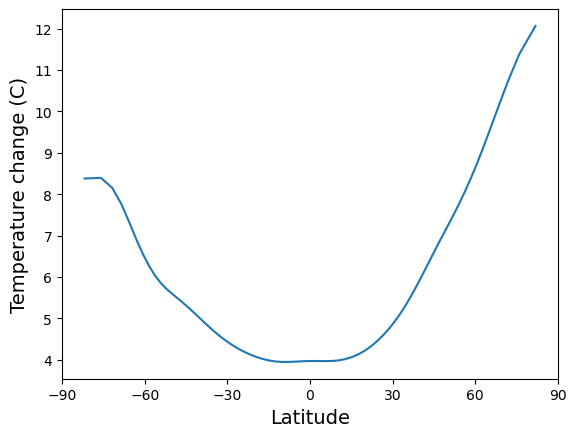

In [14]:
plt.plot(phi,T[:,j]) #plot zonal mean temperature change
plt.xticks(np.arange(-90, 91, 30))
#plt.yticks(np.arange(0, 10, 2))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Temperature change (C)', fontsize=14)
plt.show()

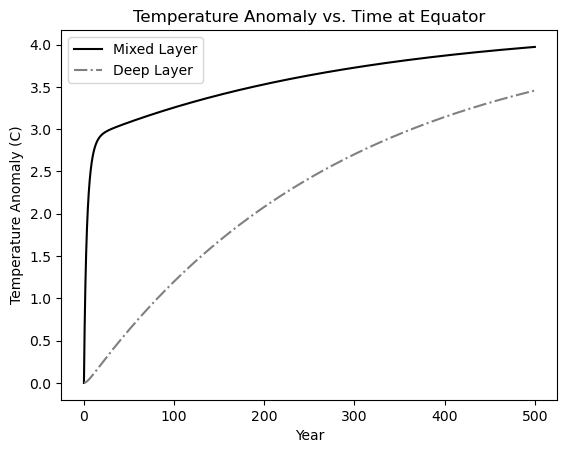

In [15]:
time = np.arange(T.shape[1])/itperyear
plt.colorbar
plt.plot(time,T[50,:],label='Mixed Layer',c='black')
plt.plot(time,T0[50,:],label='Deep Layer',c='gray',linestyle='dashdot')
plt.title("Temperature Anomaly vs. Time at Equator")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (C)")
plt.legend()

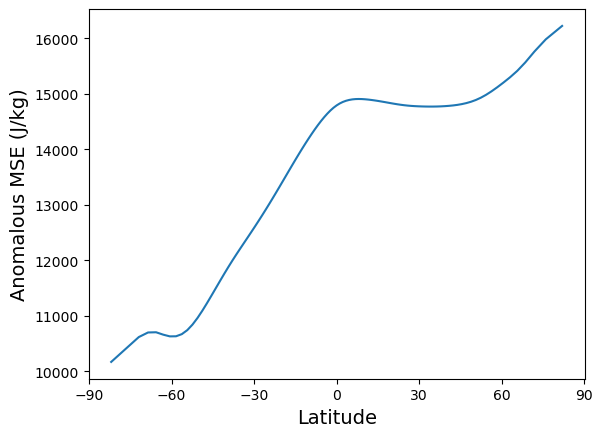

In [17]:
plt.plot(phi,h_pert) #plot MSE anomaly
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Anomalous MSE (J/kg)', fontsize=14)
plt.show()

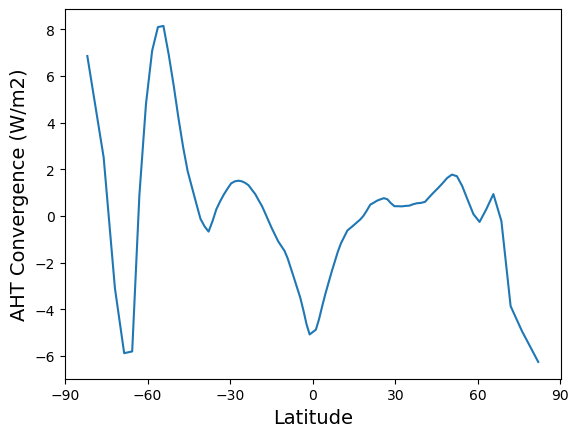

In [18]:
plt.plot(phi,-divF_pert) #plot anomalous AHT convergence 
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('AHT Convergence (W/m2)', fontsize=14)
plt.show()

### Plot Climatological Hydrology

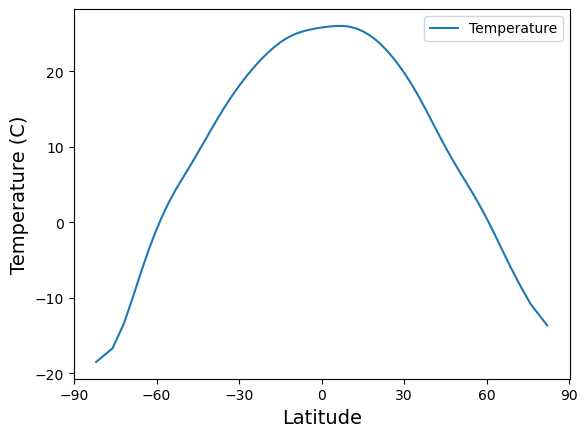

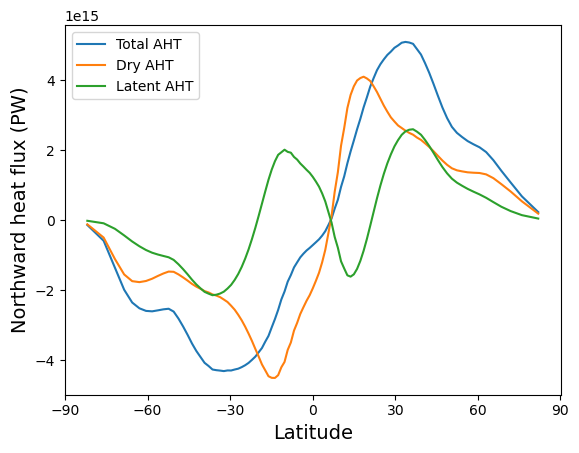

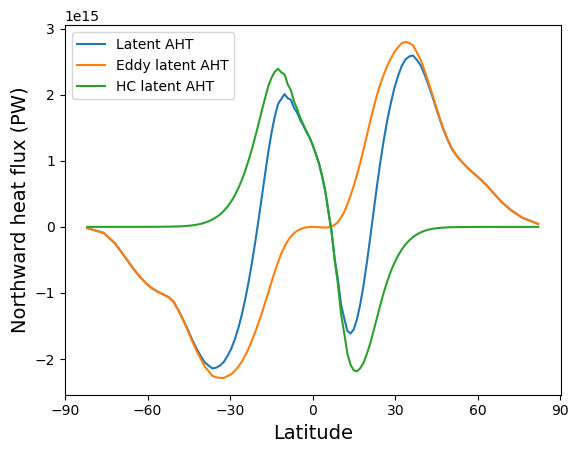

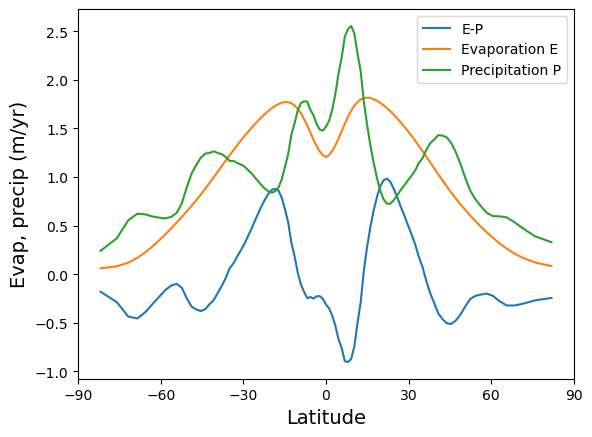

In [19]:
# Figures for climatology prior to 4xCO2 perturbation (PARTS A and B of HW4)

plt.plot(phi,T_ctrl)
plt.legend(["Temperature"])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Temperature (C)', fontsize=14)
plt.show()

plt.plot(phi,F_ctrl) #total heat transport
plt.plot(phi,F_ctrl-F_LH_ctrl) #dry
plt.plot(phi,F_LH_ctrl) #latent
plt.legend(["Total AHT", "Dry AHT", "Latent AHT"])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Northward heat flux (PW)', fontsize=14)
plt.show()

plt.plot(phi,F_LH_ctrl) #latent heat transport
plt.plot(phi,F_LH_eddy_ctrl) #eddy component of latent
plt.plot(phi,-L*V_ctrl*q_ctrl) #Hadley cell component of latent 
plt.legend(["Latent AHT", "Eddy latent AHT", "HC latent AHT"])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Northward heat flux (PW)', fontsize=14)
plt.show()

plt.plot(phi,E_m_P_ctrl) #Evaporation minus precipitation (E-P) in m/yr
plt.plot(phi,E_ctrl/(L*rho)*np.pi*1e7) #Evaporation in m/yr
plt.plot(phi,P_ctrl/(L*rho)*np.pi*1e7) #Precipitation in m/yr
plt.legend(["E-P", "Evaporation E", "Precipitation P"])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Evap, precip (m/yr)', fontsize=14)
plt.show()

### Plot perturbation hydrologic cycle

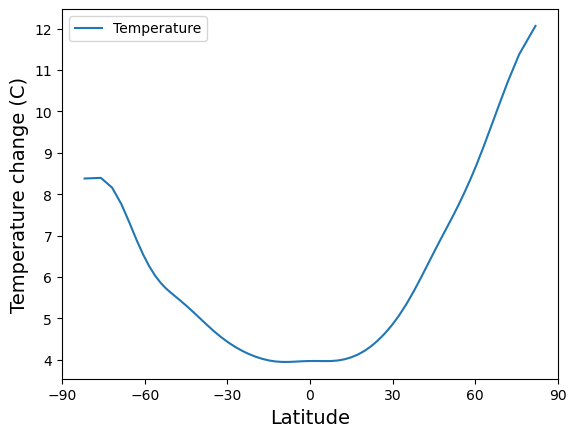

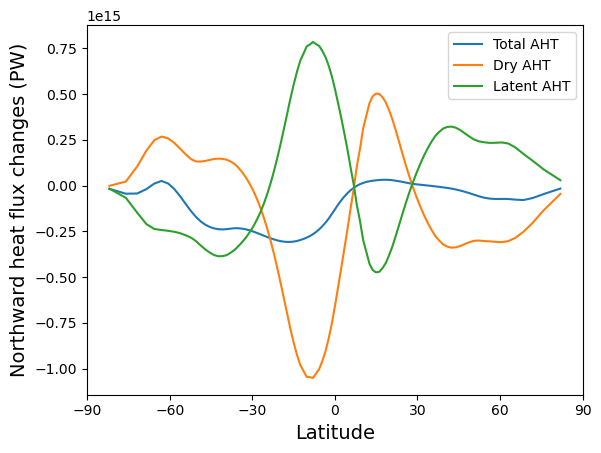

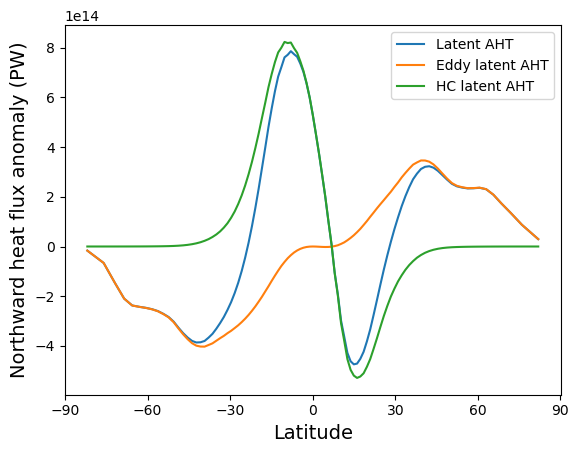

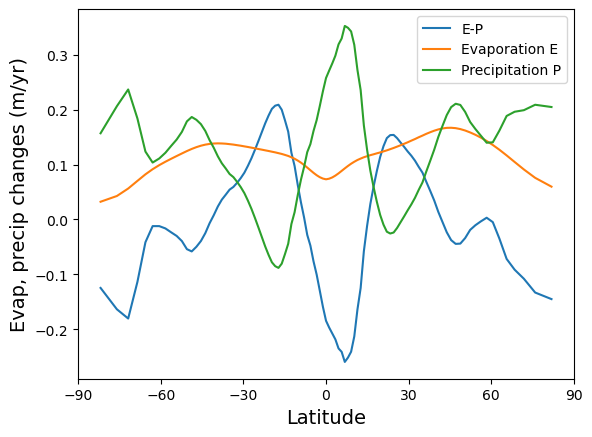

In [20]:
# Figures for perturbation (changes under 4xCO2, relative to climatology values above) (PARTS C, D, E of HW4)

plt.plot(phi,T[:,j])
plt.legend(["Temperature"])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Temperature change (C)', fontsize=14)
plt.show()

plt.plot(phi,F_expt[:,j]-F_ctrl) #total heat transport
plt.plot(phi,(F_expt[:,j]-F_LH_expt[:,j]) - (F_ctrl-F_LH_ctrl)) #dry
plt.plot(phi,F_LH_expt[:,j] - F_LH_ctrl) #latent
plt.legend(["Total AHT", "Dry AHT", "Latent AHT"])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Northward heat flux changes (PW)', fontsize=14)
plt.show()

plt.plot(phi,F_LH_expt[:,j] - F_LH_ctrl) #latent heat transport
plt.plot(phi,F_LH_eddy_expt[:,j] - F_LH_eddy_ctrl) #eddy component of latent
plt.plot(phi,-L*V_expt[:,j]*q_expt[:,j] - (-L*V_ctrl*q_ctrl)) #Hadley cell component of latent 
plt.legend(["Latent AHT", "Eddy latent AHT", "HC latent AHT"])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Northward heat flux anomaly (PW)', fontsize=14)
plt.show()

plt.plot(phi,E_m_P_expt[:,j] - E_m_P_ctrl) #Evaporation minus precipitation (E-P) changes in m/yr
plt.plot(phi,(E_expt[:,j] - E_ctrl)/(L*rho)*np.pi*1e7) #E changes in m/yr
plt.plot(phi,(P_expt[:,j] - P_ctrl)/(L*rho)*np.pi*1e7) #P changes in m/yr
plt.legend(["E-P", "Evaporation E", "Precipitation P"])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Evap, precip changes (m/yr)', fontsize=14)
plt.show()

## **Misc Figures**

In [21]:
#This creates arrays of shape (101,499999) to store the difference between simulated and control hydrologic paramaters 
E_anomaly = np.zeros((101,E_expt.shape[1]))
P_anomaly = np.zeros((101,P_expt.shape[1]))
E_m_P_anomaly = np.zeros((101,E_m_P_expt.shape[1]))

for i in range(0,E_expt.shape[1]):
    E_anomaly[:,i] = E_expt[:,i]-E_ctrl 
    P_anomaly[:,i] = P_expt[:,i]-P_ctrl 
    E_m_P_anomaly[:,i] = E_m_P_expt[:,i]-E_m_P_ctrl

Text(0.5, 1.0, 'Temperature Anomaly')

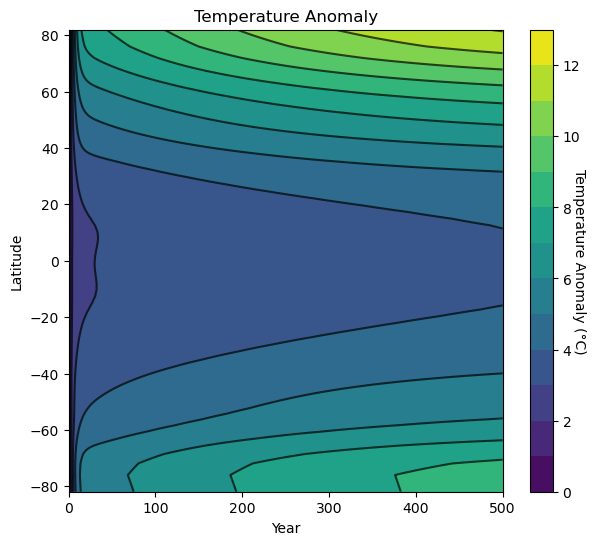

In [41]:
#Plot latitude vs. time, with temp anomaly contoured
time = np.arange(T.shape[1])/itperyear

plt.figure(figsize=(7, 6))
plt.contour(time,phi,T,levels=np.arange(0,14),colors='black',linestyles='-',alpha=0.7)
plt.contourf(time,phi,T,levels=np.arange(0,14),cmap='viridis',linestyles='-')
cbar = plt.colorbar()
cbar.set_label('Temperature Anomaly (°C)', rotation=270)
plt.xticks(np.arange(0,600,100))
plt.xlabel('Year')
plt.ylabel('Latitude')
plt.title("Temperature Anomaly")

Text(0.5, 1.0, 'Precipitation Anomaly')

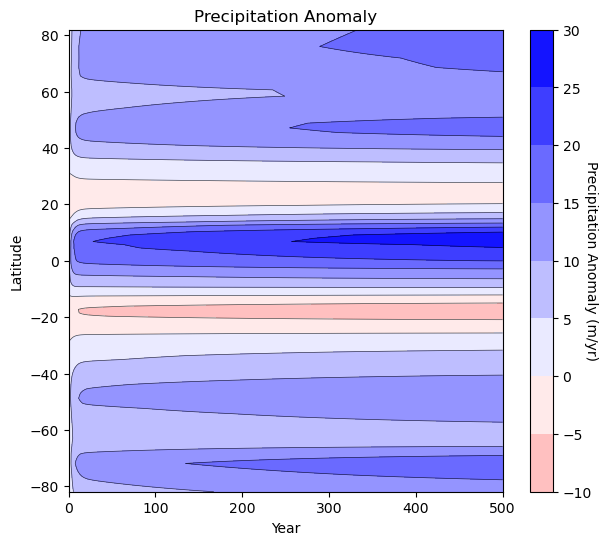

In [22]:
#Plot latitude vs time w/ precipitation anomaly contoured
time = np.arange(T.shape[1])/itperyear

plt.figure(figsize=(7, 6))
plt.contour(time,phi,P_anomaly,colors='black',linestyles='-',linewidths = 0.5, alpha=0.7)
plt.contourf(time,phi,P_anomaly,norm=colors.CenteredNorm(),cmap='bwr_r')
cbar = plt.colorbar()
cbar.set_label('Precipitation Anomaly (m/yr)', rotation=270)
plt.xticks(np.arange(0,600,100))
plt.xlabel('Year')
plt.ylabel('Latitude')
plt.title("Precipitation Anomaly")

Text(0.5, 1.0, 'Evaporation Anomaly')

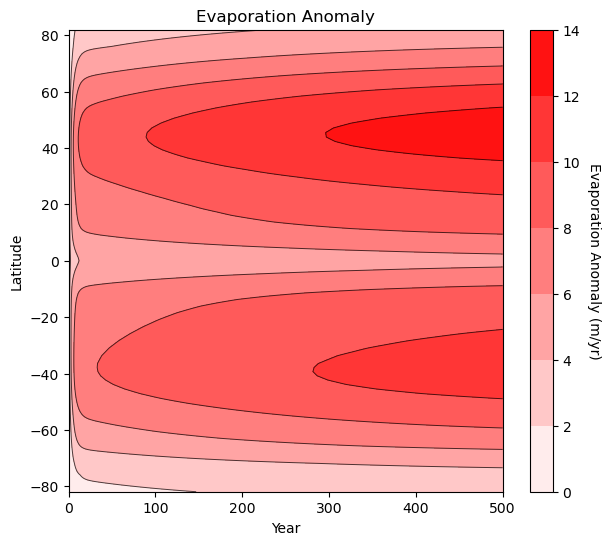

In [43]:
#Plot latitude vs time w/ evaporation anomaly contoured
time = np.arange(T.shape[1])/itperyear

plt.figure(figsize=(7, 6))
plt.contour(time,phi,E_anomaly,colors='black',linestyles='-',linewidths=0.7,alpha=0.7)
plt.contourf(time,phi,E_anomaly,norm=colors.CenteredNorm(),cmap='bwr')
cbar = plt.colorbar()
cbar.set_label('Evaporation Anomaly (m/yr)', rotation=270,labelpad=15)
plt.xticks(np.arange(0,600,100))
plt.xlabel('Year')
plt.ylabel('Latitude')
plt.title("Evaporation Anomaly")

Text(0.5, 1.0, 'Evaporation - Precipitation Anomaly')

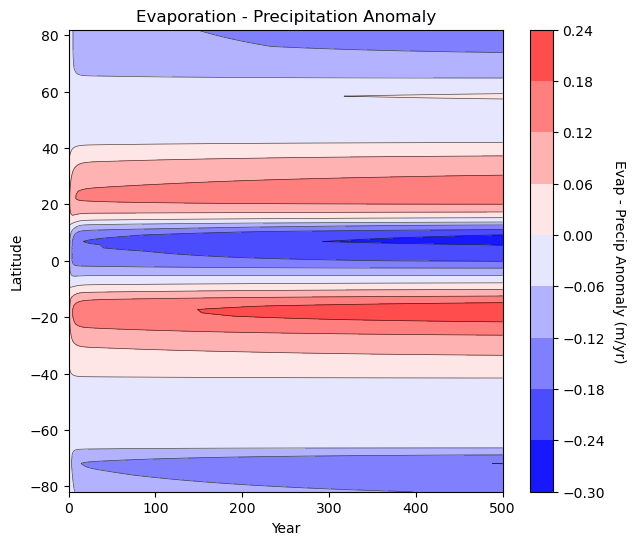

In [44]:
#Plot latitude vs time w/ evap-precip contoured
time = np.arange(T.shape[1])/itperyear

plt.figure(figsize=(7, 6))
plt.contour(time,phi,E_m_P_anomaly,colors='black',linestyles='-',linewidths=0.5,alpha=0.7)
plt.contourf(time,phi,E_m_P_anomaly,norm=colors.CenteredNorm(),cmap='bwr')
cbar = plt.colorbar()
cbar.set_label('Evap - Precip Anomaly (m/yr)', rotation=270,labelpad=15)
plt.xticks(np.arange(0,600,100))
plt.xlabel('Year')
plt.ylabel('Latitude')
plt.title("Evaporation - Precipitation Anomaly")

In [24]:
#Create array of size (101,499999) to store percentage of year 500 temperature
Max_temp = np.zeros(101)
pct_max = np.zeros((101,T.shape[1]))
for i in range(0,101):
    Max_temp[i]=T[i,:].max()
for k in range(0,101):
    pct_max[k] = T[k,:]/Max_temp[k]

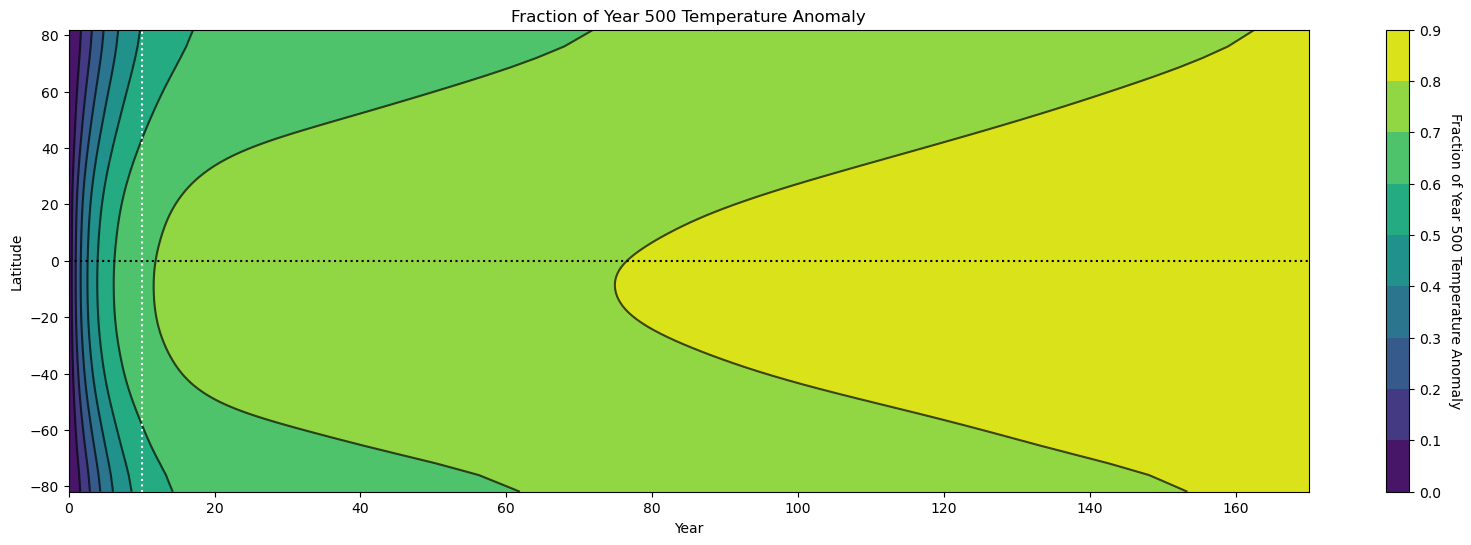

In [27]:
#Plot latitude vs. time w/ fraction of year 500 temperature anomaly contoured
time = np.arange(T.shape[1])/itperyear


plt.figure(figsize=(20, 6))
plt.contour(time,phi,pct_max,colors='black',levels=np.arange(0,1.0,0.1),linestyles='-',alpha=0.7)
plt.contourf(time,phi,pct_max,cmap='viridis',levels=np.arange(0,1.0,0.1),linestyles='-')
cbar = plt.colorbar()
cbar.set_label('Fraction of Year 500 Temperature Anomaly', rotation=270,labelpad=15)
plt.xticks([0,20,40,60,80,100,120,140,160])
plt.xlim(0,170)
plt.xlabel('Year')
plt.ylabel('Latitude')
plt.title("Fraction of Year 500 Temperature Anomaly")
plt.axhline(0,linestyle='dotted',c='black')
plt.axvline(10,linestyle='dotted',c='white')

### Calculate Some Statistics

In [90]:
#idk
def find_90_percent_indices(arr):
    indices = np.empty(arr.shape[0], dtype=int)
    for i, row in enumerate(arr):
        max_val = np.max(row)
        threshold = 0.9 * max_val
        indices[i] = np.argmax(row >= threshold)
    return indices

yr_90_percent = find_90_percent_indices(T)/itperyear

def find_75_percent_indices(arr):
    indices = np.empty(arr.shape[0], dtype=int)
    for i, row in enumerate(arr):
        max_val = np.max(row)
        threshold = 0.75 * max_val
        indices[i] = np.argmax(row >= threshold)
    return indices

yr_75_percent = find_75_percent_indices(T)/itperyear

def find_50_percent_indices(arr):
    indices = np.empty(arr.shape[0], dtype=int)
    for i, row in enumerate(arr):
        max_val = np.max(row)
        threshold = 0.5 * max_val
        indices[i] = np.argmax(row >= threshold)
    return indices

yr_50_percent = find_50_percent_indices(T)/itperyear